In [1]:
import os

import dotenv
dotenv.load_dotenv()

MPAN: str = os.environ["ELECTRICITY_MPAN"]
SERIAL: str = os.environ["ELECTRICITY_SERIAL"]

In [2]:
# from octopus import OctopusEnergyAPIClient

# with OctopusEnergyAPIClient() as client:
#     meter = client.get_electricity_meter_point_v1(MPAN)
#     gsp = meter["gsp"]

#     print("Tariffs:")
#     for product in client.list_products_v1():
#         if product["is_business"] or product["is_prepay"] or product["is_restricted"]:
#             continue
#         product = client.retrieve_product_v1(product["code"])
#         if "Tracker" in product["display_name"]:
#             print(product)
#         if "Outgoing" in product["display_name"] or "Import" in product["display_name"] or "Export" in product["display_name"]:
#             continue
#         if gsp in product["single_register_electricity_tariffs"]:
#             if "direct_debit_monthly" not in product["single_register_electricity_tariffs"][gsp]:
#                 continue
#             print(f"{product['display_name']} ({product['code']}):")
#             values = product["single_register_electricity_tariffs"][gsp]["direct_debit_monthly"]
#             print(f"  {values['code']}")
#             print(f"  Standing charge: {values['standing_charge_inc_vat']} p")
#             print(f"  Unit rate: {values['standard_unit_rate_inc_vat']} p")
#         if gsp in product["dual_register_electricity_tariffs"]:
#             if "direct_debit_monthly" not in product["dual_register_electricity_tariffs"][gsp]:
#                 continue
#             print(f"{product['display_name']} ({product['code']}):")
#             values = product["dual_register_electricity_tariffs"][gsp]["direct_debit_monthly"]
#             print(f"  {values['code']}")
#             print(f"  Standing charge: {values['standing_charge_inc_vat']} p")
#             print(f"  Day unit rate: {values['day_unit_rate_inc_vat']} p")
#             print(f"  Night unit rate: {values['day_unit_rate_inc_vat']} p")

In [3]:
from datetime import date, timedelta

import pandas as pd

from octopus import OctopusEnergyAPIClient

with OctopusEnergyAPIClient() as client:
    # TODO: get this from API
    PRODUCT_CODE = "LOYAL-FIX-12M-23-12-08"

    meter = client.get_electricity_meter_point_v1(MPAN)
    gsp = meter["gsp"]

    product = client.retrieve_product_v1(PRODUCT_CODE)
    if gsp not in product["single_register_electricity_tariffs"]:
        raise ValueError(f"GSP {gsp} not found in product {PRODUCT_CODE}")
    tariff = product["single_register_electricity_tariffs"][gsp]["direct_debit_monthly"]

    df_consumption = pd.DataFrame.from_records(client.list_electricity_meter_consumption_v1(MPAN, SERIAL, period_from=date.today() - timedelta(days=7)))

    df = df_consumption.copy()
    df["interval_start"] = pd.to_datetime(df["interval_start"])
    df["interval_end"] = pd.to_datetime(df["interval_end"])
    df["time"] = df["interval_start"] + (df["interval_end"] - df["interval_start"]) / 2
    print(df["interval_start"])

0     2024-09-07 00:30:00+01:00
1     2024-09-07 00:00:00+01:00
2     2024-09-06 23:30:00+01:00
3     2024-09-06 23:00:00+01:00
4     2024-09-06 22:30:00+01:00
                 ...           
333   2024-08-31 02:00:00+01:00
334   2024-08-31 01:30:00+01:00
335   2024-08-31 01:00:00+01:00
336   2024-08-31 00:30:00+01:00
337   2024-08-31 00:00:00+01:00
Name: interval_start, Length: 338, dtype: datetime64[ns, UTC+01:00]


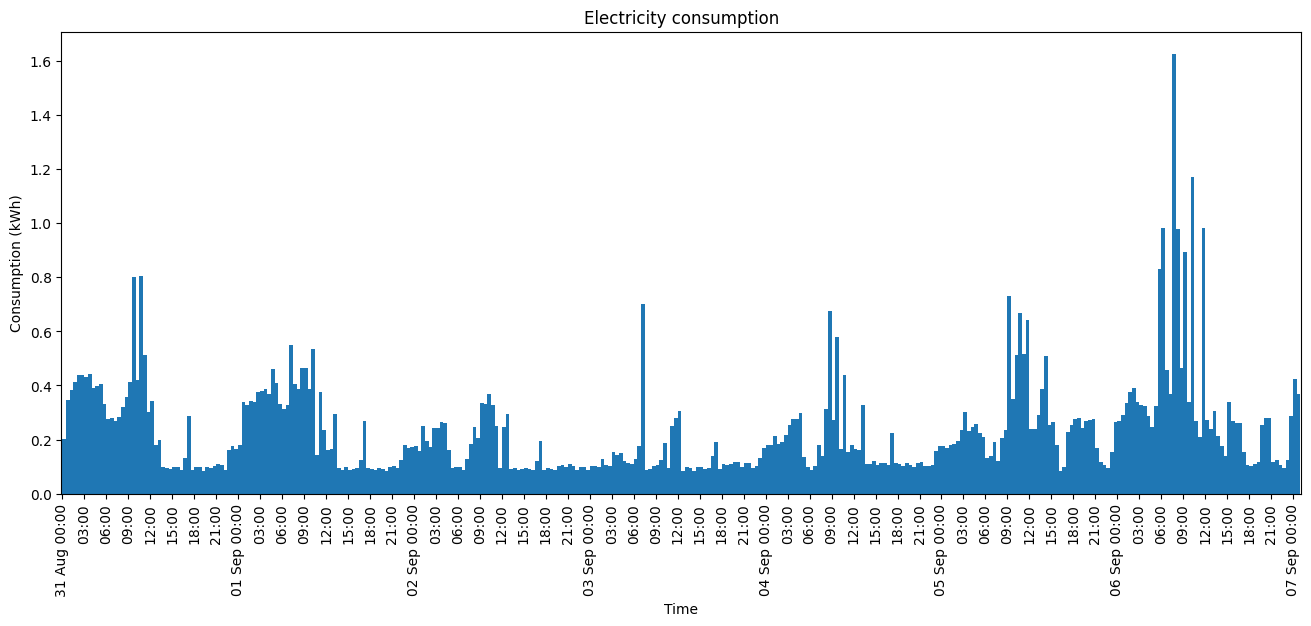

In [4]:
data = df.set_index("interval_start")["consumption"]

ax = data.plot(kind="bar", align="edge", width=1, figsize=(16, 6))
ax.set_title("Electricity consumption")
ax.set_xlabel("Time")
ax.set_ylabel("Consumption (kWh)")

x_ticks = []
x_tick_labels = []

for i, time in enumerate(data.index.sort_values()):
    if time.hour == 0 and time.minute == 0:
        x_ticks.append(i)
        x_tick_labels.append(time.strftime("%d %b %H:%M"))
    elif i % 6 == 0:
        x_ticks.append(i)
        x_tick_labels.append(time.strftime("%H:%M"))

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)
ax.tick_params(axis="x", rotation=90)

In [5]:
with OctopusEnergyAPIClient() as client:
    # FIXME: assuming single rate tariff
    df_unit_rates = pd.DataFrame.from_records(client.list_electricity_tariff_standard_unit_rates_v1(PRODUCT_CODE, tariff["code"]))

df_unit_rates

,value_exc_vat,value_inc_vat,valid_from,valid_to,payment_method
0,26.1193,27.425265,2023-12-08T00:00:00Z,None,None
